# 1 Mastering Advanced Network Construction

Complex networks are rarely constructed one node and one edge at a time.
Instead, they are generated from **matrix data**, **edge lists**, **node dictionaries**,
**probability distributions**, and other native Python and third-party data
structures. As a complex network analyst, you need to be familiar with the
**NetworkX interfaces to the real world**.

In this section, you will learn:

- how to convert Python and third-party data structures (namely, **Pandas DataFrames** and **NumPy matrices**) into **NetworkX** graphs and back, and 
- how to generate synthetic networks.

## 1.1 Create Networks from Adjacency and Incidence Matrices

Mathematical graphs as collections of nodes and edges are
not the only way to represent complex networks. Researchers
and practitioners often use tabular (matrix) data to describe
networks. The two most popular matrix-based descriptions
are **adjacency** and **incidence matrices**.

### 1.1.1 Adjacency Matrix, the Python Way




An adjacency matrix A is a square $N\times N$ matrix, where $N$ is the size of the graph
to be defined. The row and column indexes indicate the source and target
nodes, respectively. Depending on the network type, the acceptable range,
properties, and interpretation of the matrix elements differ. If a network
belongs to more than one type (say, weighted and directed), consider all relevant
properties and interpretations (see table below).


| Network type    | Adjacency matrix                              | Interpretation                               |
|-----------------|-----------------------------------------------|----------------------------------------------|
| Simple          | Only 0s or 1s, and no 1s on the main diagonal | Absence/presence of an edge                  |
| Weighted        | At least one floating-point number            | Numbers are edge weights                     |
| With self-loops | At least one non-zero on the main diagonal    | Same as above                                |
| Signed          | At least one negative number                  | Same as above                                |
| Undirected      | Symmetric                                     | Same as above                                |
| Multigraph      | Not possible                                  | Cannot be represented as an adjacency matrix |


As an example, here’s an adjacency matrix for the linear timeline of Abraham
Lincoln:

<img width="200" src="https://drive.google.com/uc?export=view&id=1661N-zE4kC5LfQGa33hUCyi9Q5C0b_DX"> <img width="200" src="https://drive.google.com/uc?export=view&id=1HpWEIsxBcY1FWI1UYQdgudViRpURDecB">


The networks have five nodes each (the matrices are $5\times5$). The left network
has four edges (the matrix has four 1s), and the right network has an extra
edge. The networks are simple (the matrices have only 0s and 1s, and no 1s
are on the main diagonal), unweighted, and unsigned. The networks are
directed (the matrices are not symmetric). The additional 1 in the lower-left
corner of the matrix on the right converts the linear network into a ring by
connecting the last event (death) to the first event (birth). If Abraham Lincoln had
believed in reincarnations, he would have chosen the right matrix :-)


As a side note, **the sum of all 1s in any column or row of an adjacency matrix
equals the indegree or outdegree**, respectively, of the corresponding node.
The most common way of representing matrices in pure **Python** is in the form
of a **list of lists**. The right previous matrix is a list of five lists, one list per row.
Suppose it is given to us (say, produced by another function elsewhere in our
program):

In [0]:
A = [[0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1],
     [.1, 0, 0, 0, 0]]
A

[[0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0.1, 0, 0, 0, 0]]

Note that since the reincarnation is not inevitable at all, not even in the case
of Honest Abraham, we set the weight of the death-to-birth edge to 0.1.

**How can we convert this matrix to a graph?** There are at least three ways:
- one uses pure Python and NetworkX,
- and the other rely on NumPy  
- and Pandas

If performance is not an issue (if your network has fewer than a couple of
thousand nodes), the pure Python solution may make you feel more comfortable,
especially if you have never used NumPy. 

Remember that any non-zero element in the adjacency matrix represents an edge from the “row node” to the “column node.” Create an empty directed graph, enumerate each matrix
element twice (by rows and then by columns), and extract non-zero elements.
Their indexes represent network edges, which you can add to the graph by
calling **G.add_edges_from()**.

In [0]:
import networkx as nx
  
# directed graph  
G = nx.DiGraph()

# nested list comprehension
edges = [(i,j) for i,row in enumerate(A) for j,column in enumerate(row) if A[i][j]]

# add edges
G.add_edges_from(edges)

print(G.edges(data=True))

[(0, 1, {}), (1, 2, {}), (2, 3, {}), (3, 4, {}), (4, 0, {})]


By default, NetworkX assumes that all edges have the weight of 1, and does not
display weights as edge attributes. If the matrix represents signed or unsigned
weights (rather than absence/presence), you can modify the code to incorporate
the “weight” attribute:

In [0]:
# directed graph  
G = nx.DiGraph()

# nested list comprehension
edges = [(i,j, {"weight": A[i][j]}) for i,row in enumerate(A) for j,column in enumerate(row) if A[i][j]]

# add edges
G.add_edges_from(edges)

print(G.edges(data=True))

[(0, 1, {'weight': 1}), (1, 2, {'weight': 1}), (2, 3, {'weight': 1}), (3, 4, {'weight': 1}), (4, 0, {'weight': 0.1})]


### 1.1.2 Adjacency Matrix, the Numpy Way

The NumPy way is somewhat more concise, but you must convert the list of
lists to a 2D matrix and give NetworkX a hint about the network type.

In [0]:
import numpy as np

A_mtx = np.matrix(A)
G = nx.from_numpy_matrix(A_mtx, create_using=nx.DiGraph())

print(G.edges(data=True))

[(0, 1, {'weight': 1.0}), (1, 2, {'weight': 1.0}), (2, 3, {'weight': 1.0}), (3, 4, {'weight': 1.0}), (4, 0, {'weight': 0.1})]


As a bonus, the **Numpy is significantly faster for large networks**. Also, note
how Numpy intelligently treated matrix elements as edge weights!
You can program the reverse transformation with **nx.to_numpy_matrix(G)**:

In [0]:
# Produces a numpy 2D matrix
B_mtx = nx.to_numpy_matrix(G)

print(B_mtx)

[[0.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.1 0.  0.  0.  0. ]]


To convert the matrix back to a list of lists, call method tolist():

In [0]:
B_lst = B_mtx.tolist()
B_lst

[[0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.1, 0.0, 0.0, 0.0, 0.0]]

### 1.1.3 Adjacency Matrix, the Pandas Way

The most versatile connection to date is between NetworkX and Pandas. Converting a NetworkX graph to a Pandas adjacency matrix **costs one function
call**, just like almost any other popular operation in Pandas. Before we do
so, let’s first relabel the graph nodes to allow at least some meaningful
interpretation:

In [0]:
labels = "Born", "Married", "Elected Rep", "Elected Pres", "Died"

# change nodes label inplace
nx.relabel_nodes(G, dict(enumerate(labels)), copy=False)

# create a dataframe from a networkx graph
df = nx.to_pandas_adjacency(G)

df

,Born,Married,Elected Rep,Elected Pres,Died
Born,0.0,1.0,0.0,0.0,0.0
Married,0.0,0.0,1.0,0.0,0.0
Elected Rep,0.0,0.0,0.0,1.0,0.0
Elected Pres,0.0,0.0,0.0,0.0,1.0
Died,0.1,0.0,0.0,0.0,0.0


In [0]:
edges = nx.to_pandas_edgelist(G)
edges

,source,target,weight
0,Born,Married,1.0
1,Married,Elected Rep,1.0
2,Elected Rep,Elected Pres,1.0
3,Elected Pres,Died,1.0
4,Died,Born,0.1


Let’s build Honest Abraham's lifetime network from a data frame. First, create a
data frame—in the real world, it would be an output of another part of the
same program. Second, call **nx.from_pandas_adjacency()**. No magic involved.


In [0]:
import pandas as pd

edges = pd.DataFrame({"from": {0: "Died", 1: "Elected Rep", 2: "Married", 3: "Born",4: "Elected Pres"},
                   "to": {0: "Born", 1: "Elected Pres", 2: "Elected Rep", 3: "Married",4: "Died"},
                   "weight": {0: 0.1, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}})
edges

,from,to,weight
0,Died,Born,0.1
1,Elected Rep,Elected Pres,1.0
2,Married,Elected Rep,1.0
3,Born,Married,1.0
4,Elected Pres,Died,1.0


In [0]:
G = nx.from_pandas_edgelist(edges,*edges.columns)
G.edges(data=True)

EdgeDataView([('Died', 'Born', {'weight': 0.1}), ('Died', 'Elected Pres', {'weight': 1.0}), ('Born', 'Married', {'weight': 1.0}), ('Elected Rep', 'Elected Pres', {'weight': 1.0}), ('Elected Rep', 'Married', {'weight': 1.0})])

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


The [Enron email network](http://snap.stanford.edu/data/email-Enron.html) consists of 1,148,072 emails sent between employees of Enron between 1999 and 2003. Nodes in the network are individual employees and edges are individual emails. It is possible to send an email to oneself, and thus this network contains loops. In this exercise we will use a subset of Enron email consists of 36692 nodes and 367662 edges.

1. Read the file **"email-Enron.txt"** (tip: columns are separeted by a "\t") to a dataframe named **"edges"**. 
2. Use **nx.from_pandas_edgelist()** to create a directed graph **g_enron** from **"edges"**. tip: configure the parameter **create_using** to **nx.Digraph**.
3. Find the number of nodes and edges of **g_enron**.

In [0]:
# put your code here

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

1. Read the file **"out.enron"** (tip: columns are separeted by a white space) to a dataframe named **"edges2"**. 
2. Use **nx.from_pandas_edgelist()** to create a directed graph **g_enron2** from **"edges2"**
  - configure the parameter **create_using** to **nx.Digraph**.
  - source to **"To"**
  - target to **"From"**
  - edge_attr to a list contains **"Weight"** and **"Timestamp"**.
3. Find the number of nodes and edges of **g_enron2**.
4. Visualize the data of **edges2**.

In [0]:
# put your code here

### 1.1.4 Incidence Matrix




An incidence matrix J is a rectangular $N\times M$ matrix, where 
- $N$ is the number of
nodes 
- and $M$ is the number of edges. 
- a 1 at J[i,j] means that the node i is incident to the edge j. 
- all other elements of J are 0s. 
- if the represented graph is directed, the start node is designated with 1 and the end node with -1.

Unlike an adjacency matrix, **an incidence matrix easily allows parallel edges**.

However, it has its **weak points**: 
- weighted networks cannot be represented
- and an incidence matrix of a typical complex network has a larger memory
footprint than the adjacency matrix of the same network.

Function **nx.incidence_matrix(G)** returns the incidence matrix of G as a so-called
**sparse matrix**. (Pass the optional parameter **oriented=True** to distinguish start
and end nodes.) You can convert a sparse matrix to a dense one with **G.todense()**:



In [0]:
J = nx.incidence_matrix(G, oriented=True).todense()
J

matrix([[-1., -1.,  0.,  0.,  0.],
        [ 1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0., -1., -1.],
        [ 0.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1.]])

Here’s how we read the results: edge number 0 starts at node 1 (because
J[1,0]==1) and ends at node 0 (because J[0,0]==-1); edge number 1 starts at node
3 (because J[3,1]==1) and ends at node 0 (because J[0,1]==-1), and so on.

In [0]:
import sys
print(sys.getsizeof(nx.incidence_matrix(G, oriented=True)))
print(sys.getsizeof(nx.incidence_matrix(G, oriented=True).todense()))

56
136


## 1.2 Generate Synthetic Networks

You have read in [Complex Network Analysis book](https://pragprog.com/book/dzcnapy/complex-network-analysis-in-python), that not only
can networks be built from experimental, real-world data, but they can also
be **synthesized**. 

Synthetic networks can be regular (constructed by executing
deterministic algorithms) or complex (emerge from probability distributions).
NetworkX functions that build synthetic network graphs are called **graph generators**. Let’s start with the “classic” networks: paths, cycles, stars, complete graphs, trees, and grids.

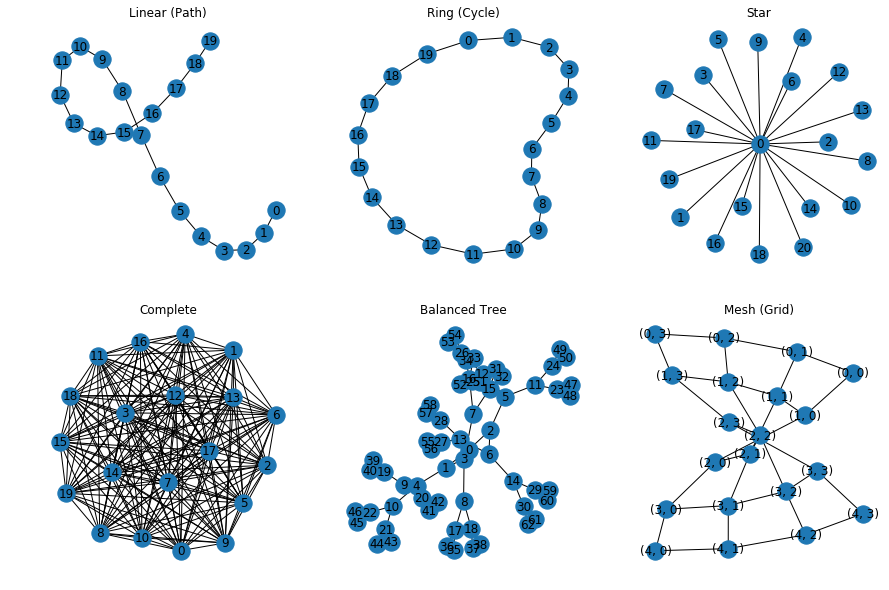

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# Generate and draw classic networks
G0 = nx.path_graph(20)
G1 = nx.cycle_graph(20)
G2 = nx.star_graph(20)
G3 = nx.complete_graph(20)
G4 = nx.balanced_tree(2, 5)
G5 = nx.grid_2d_graph(5, 4)

graphs = [G0,G1,G2,G3,G4,G5]

names = ["Linear (Path)", "Ring (Cycle)", 
         "Star", "Complete", "Balanced Tree", "Mesh (Grid)"]

for graph,title,plot in zip(graphs,names,subplots):
  nx.draw_networkx(graph, ax=plot)
  plot.set_title(title)
  plot.axis("off")

The first four functions need to know the total number of nodes. There is only
one way to generate the edges for these types of graphs. 

For a balanced tree, you must provide the branching factor r (the number of children of a non-leaf node) and the height h (the height does not include the root node of the tree). A balanced tree has $r^{h+1}-1$ nodes. In our example, G5 is a five-level binary tree
with $2^{5+1}-1=63$ nodes. To build a two-dimensional grid (mesh) like G6, specify
the number of rows $n$ and columns $m$, and get a graph with $m\times n$ nodes.


**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

1. Change the paramenters of the previous six graphs and visualize them using Circos Plot (nxviz). tip: nxviz uses networkx 2.2. In this notebook we are using network 2.3. After solve this exercise install again network 2.3. 

In [0]:
!pip install git+https://github.com/ericmjl/nxviz networkx==2.3

In [0]:
# put your code here


It is worth remembering that **these six networks are not complex because
they have a predictable, regular, and easily describable structure**. But the
networks in the following figure are randoms, though defined by four different
random models  characterize the nature of the interconnecting edges:

- **Erdös–Rényi**: the probability of edge creation.
- **Watts–Strogatz**: the initial number of neighbors and the probability of edge rewiring
- **Barabási–Albert**: the number of edges to attach from a new node
- **Holme–Kim**: the same as above, plus the probability of adding a triangle
for each added edge.

An undirected **Erdös–Rényi** graph, also known as a **binomial graph**, contains
$N$ nodes. It could have up to $N\times(N-1)/2$ edges, but each edge is instantiated with the probability of **p**. As a result, the expected number of edges is $p×N×(N-1)/2$.
If $p==0$, then the network falls apart into isolated nodes. If $p==1$, the network
becomes a complete graph. 

Number of edges P(0):0
Number of edges P(0.05):72
Number of edges P(0.1):119
Number of edges P(0.25):305
Number of edges P(0.5):617
Number of edges P(1):1225


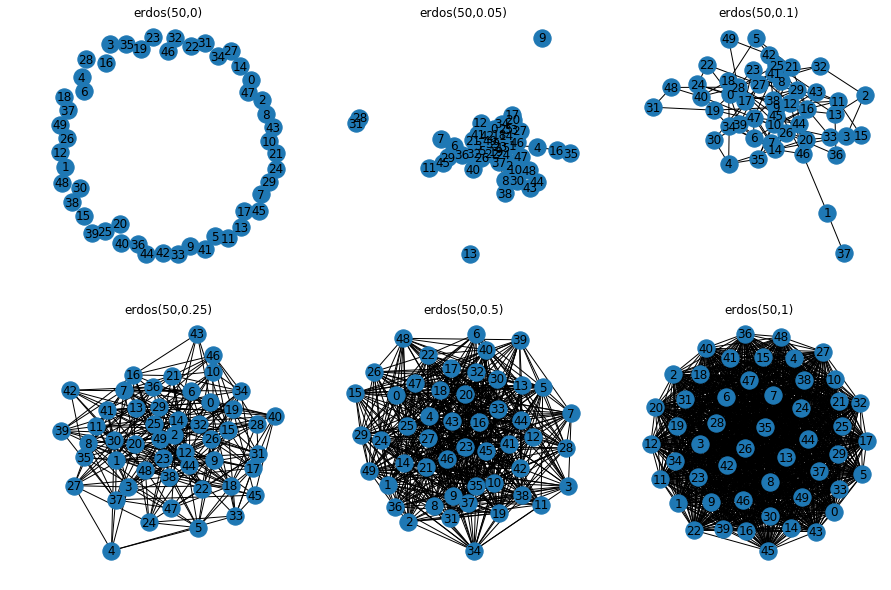

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# probabilities
probs = [0, 0.05, 0.10, 0.25, 0.5, 1]

for prob,plot in zip(probs,subplots):
  # Generate a erdos graph with probability prob
  G0 = nx.erdos_renyi_graph(50, prob)
  print("Number of edges P(" + str(prob) + "):" + str(G0.number_of_edges()))
  nx.draw_networkx(G0, ax=plot)
  plot.set_title("erdos(50," + str(prob) + ")")
  plot.axis("off")

**If you have no definite idea** about what kind of network you want, use the
**Erdös–Rényi** model. 

However, a **Watts–Strogatz** graph is a **much more realistic**
approximation of **a real-world social network**. The model arranges $N$ nodes in
a ring, connects each node to $k$ ring neighbors, and then “rewires” any edge
—reconnects one of its ends to a randomly chosen node—with the probability
of $p$. The rewired edges typically go across the ring. They **create an illusion of a
[small world](https://en.wikipedia.org/wiki/Small-world_network), where geometrically remote nodes may be connected with a short
path**. The model explains the phenomenon of **“six degrees of separation"**, which
claims that, on average, any two people on Earth are only [six handshakes apart
from each other](https://en.wikipedia.org/wiki/Six_degrees_of_separation).

Number of edges P(0):100
Number of edges P(0.05):100
Number of edges P(0.1):100
Number of edges P(0.25):100
Number of edges P(0.5):100
Number of edges P(1):100


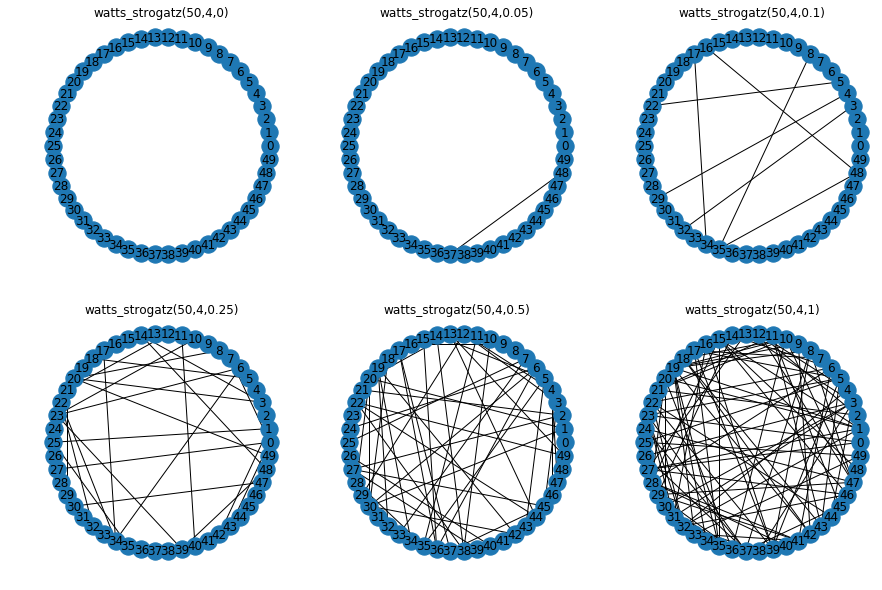

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# probabilities
probs = [0, 0.05, 0.10, 0.25, 0.5, 1]

for prob,plot in zip(probs,subplots):
  # Generate a watts-strogatz graph with probability prob
  G0 = nx.connected_watts_strogatz_graph(50, 4, prob)
  pos = nx.circular_layout(G0)
  print("Number of edges P(" + str(prob) + "):" + str(G0.number_of_edges()))
  nx.draw_networkx(G0, pos=pos, ax=plot)
  plot.set_title("watts_strogatz(50,4," + str(prob) + ")")
  plot.axis("off")

Unfortunately, no matter how you twist them, nodes in **Watts–Strogatz** networks
do not form tight communities, and this **makes “small-world” networks
somewhat unrealistic**, too.

The **Barabási–Albert** preferential attachment model adds another level of realism to synthetic social networks. It uses the **principle of preferential attachment**. When a new node is about to join an existing network, it is likely to make $k$ connections to the
nodes with the highest degree. The model stimulates the emergence of hubs
—“celebrity” nodes with disproportionately many connections.

Number of edges N(1):49
Number of edges N(2):96
Number of edges N(3):141
Number of edges N(4):184
Number of edges N(5):225
Number of edges N(10):400


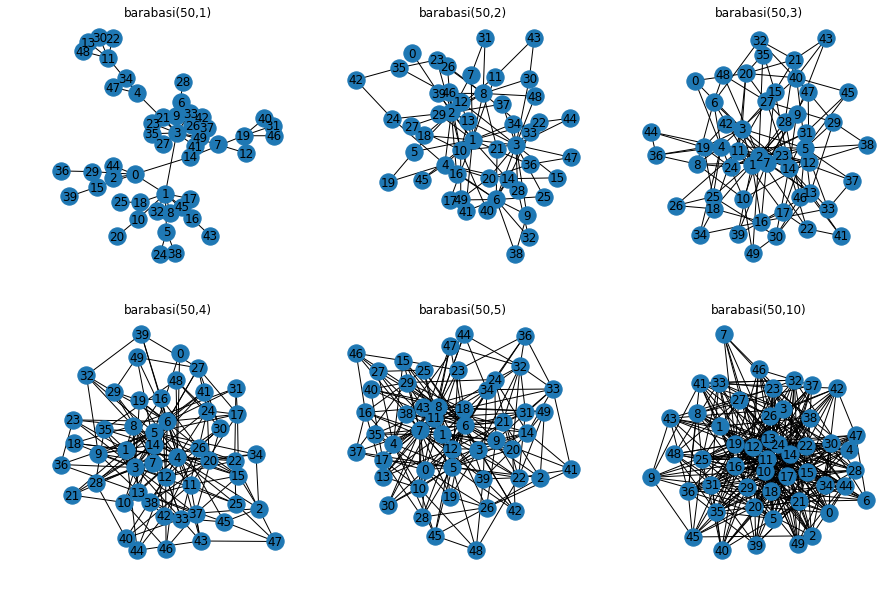

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# number of neighbors
neighs = [1, 2, 3, 4, 5, 10]

for neigh,plot in zip(neighs,subplots):
  # Generate a barabasi graph with k connections to the nodes with the highest degree
  G0 = nx.barabasi_albert_graph(50, neigh)
  print("Number of edges N(" + str(neigh) + "):" + str(G0.number_of_edges()))

  nx.draw_networkx(G0, ax=plot)
  plot.set_title("barabasi(50," + str(neigh) + ")")
  plot.axis("off")

The **Holme–Kim** model goes one step further. After adding $k$ edges, it also adds
**triads** with the probability of $p$, making the synthetic network even more clustered and lifelike.


Number of edges P(0):184
Number of edges P(0.05):183
Number of edges P(0.1):184
Number of edges P(0.25):183
Number of edges P(0.5):183
Number of edges P(1):184


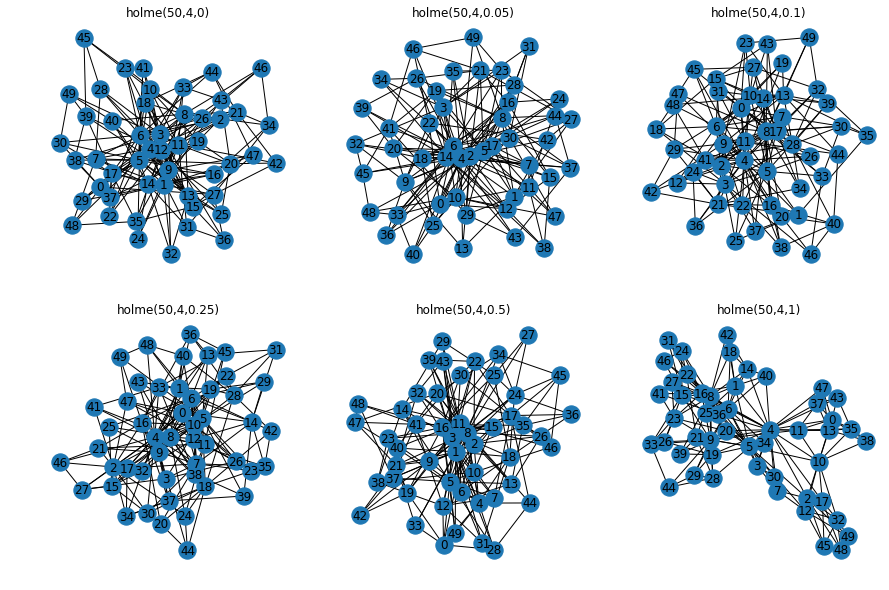

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# probabilities
probs = [0, 0.05, 0.10, 0.25, 0.5, 1]

for prob,plot in zip(probs,subplots):
  # Generate a holme-kim graph with probability prob
  G0 = nx.powerlaw_cluster_graph(50, 4, prob)
  print("Number of edges P(" + str(prob) + "):" + str(G0.number_of_edges()))

  nx.draw_networkx(G0, ax=plot)
  plot.set_title("holme(50,4," + str(prob) + ")")
  plot.axis("off")